#  Similarity

### This project includes stacks/frameworks like Python as the programming language, PyTorch and Sci-Kit Learn for using pre-trained Machine Learning models (Vision Transformers), NumPy for matrix calculations, PIL for Image transformations and Matplotlib for visual comparisons

In [25]:
# Importing necessary libraries and mounting personal google drive to feed the texture images
import numpy as np
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor, ViTModel
import torch

I have already resized the images to 224x224 in my local machine using the code below and uploaded the resized images to my google drive to avoid large image sizes and repeated processing of large image files

In [26]:
input_dir = 'mydata'
resized_imgs_dir = './resized_images/'
norm_imgs_dir = './normalized_images/'

I used a python script ("requests" library) to download all texture zip files in an automted fashion to get a diverse set of embeddings, eventually gathering 93 different Wood Textures. Once again I used a python dcript ("zipfile" library) to extract all zip files sequentially in an automated fashion to avoid manual extraction and save time.

On extraction of these files I found a set of images name a spherical 3D demo image, Color Map image, Displacement, Roughness and Normal Maps. With Color being the most relevant I chose those images to generate embedddings.

For Future scope and discussion, we can inculcate other Image maps for specific similarites, like Displacement for Pattern similarity, Normal and Roughness maps for light shader similarities and more.

In [27]:
target_size = (224, 224)

for filename in os.listdir(input_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(input_dir, filename)
        image = Image.open(image_path)
        image = image.resize(target_size)
        output_path = os.path.join(resized_imgs_dir, filename)
        image.save(output_path)

In [28]:
# Normalizing images for each pixel by using this specific method and not the predefined function
# As it is found important on how we normalize the images in later stages
# For each pixel = (Value - Mean) / Standard Deviation
for filename in os.listdir(resized_imgs_dir):
    image_path = os.path.join(resized_imgs_dir, filename)
    image = Image.open(image_path)

    image = np.array(image) / 255.0

    mean = np.mean(image)
    image -= mean

    std = np.std(image)
    image /= std

    output_path = os.path.join(norm_imgs_dir, filename)
    normalized_image = Image.fromarray((image * 255).astype('uint8'))
    normalized_image.save(output_path)

### Now to choose the model to calculate embeddings is an important choice to make. After reading about Vision Transformers and going through models on hugging face, I decided to choose the following 3 models
1. openai/clip-vit-large-patch14
2. google/vit-base-patch16-224-in21k
3. google/vit-large-patch16-224-in21k

1. OpenAI's model did not perform well being a Zero Shot Classification model
2. Google's vit-base-patch16-224-in21k and vit-large-patch16-224-in21k - both performed well but after iterating over many images, I came to a conclusion of "vit-large-patch16-224-in21k" performing better.

In [29]:
# model_name = "openai/clip-vit-large-patch14"
# model_name = "google/vit-base-patch16-224-in21k"
model_name = "google/vit-large-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTModel.from_pretrained(model_name)

Calculating Embeddings in the vector/tensor space for 93 Color Wood Texture images using the pre-trained ViT Feature extractor. I have made it a function to provide different set of image directories to create separate spaces in order to compare performances

In [30]:
# Calculating Embeddings and storing them in a tensor stack
def calc_embeddings(img_dir):
  embedding_vectors = []

  for filename in os.listdir(img_dir):
      image_path = os.path.join(img_dir, filename)
      image = Image.open(image_path)

      inputs = feature_extractor(images=image, return_tensors="pt")

      with torch.no_grad():
          output = model(**inputs)

      embedding_vector = output.last_hidden_state.mean(dim=1)
      embedding_vectors.append(embedding_vector)

  return torch.stack(embedding_vectors)

In [31]:
# Calculating embeddings for both normalized and resized images both
resized_imgs_embeddings_tensors = calc_embeddings(resized_imgs_dir)
# norm_imgs_embeddings_tensors = calc_embeddings(norm_imgs_dir)

Passing the index of image passed to find similar results for. I am using the sci-kit learn's cosine similarity function to find top 5 similar image textures.

In [34]:
# Function that accepts embedding space and image index to be queried and returns top 5 similar image texture plots
def query_similar_imgs(query_img_index, embedding_tensors):
  num_images, num_embeddings, embedding_dims = embedding_tensors.shape
  embedding_tensors_2d = embedding_tensors.reshape(num_images, -1)
  similarity_matrix = cosine_similarity(embedding_tensors_2d)
  similarity_scores = similarity_matrix[query_img_index]
  similar_textures = [(i, score) for i, score in enumerate(similarity_scores) if i != query_img_index]
  similar_textures.sort(key=lambda x: x[1], reverse=True)
  top_similar_textures = similar_textures[:4]

  plt.figure(figsize=(20, 20))
  plt.subplot(1, 5, 1)
  plt.title('Query Texture')
  plt.imshow(Image.open(os.path.join(resized_imgs_dir, os.listdir(resized_imgs_dir)[query_img_index])))
  plt.axis('off')

  for i, (texture_index, score) in enumerate(top_similar_textures):
      plt.subplot(1, 5, i + 2)
      plt.title(f'Similar Product {i + 1} - {texture_index}')
      plt.imshow(Image.open(os.path.join(resized_imgs_dir, os.listdir(resized_imgs_dir)[texture_index])))
      plt.axis('off')

  plt.show()

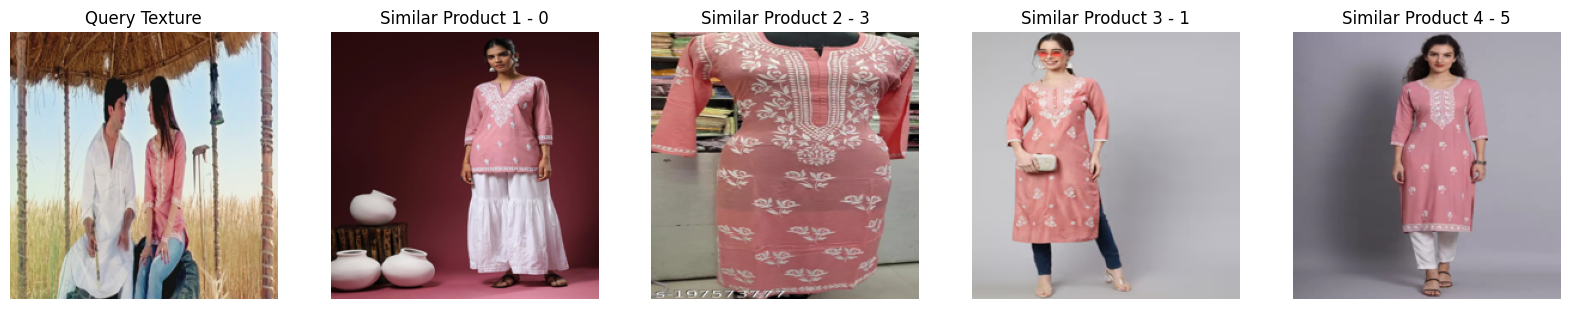

In [35]:
query_similar_imgs(4, resized_imgs_embeddings_tensors)